In [26]:
import base64
from io import BytesIO
from pathlib import Path

import pandas as pd
from matplotlib.figure import Figure

In [19]:
import sys
sys.path.append("/Users/missd/Desktop/6. Semester/6. Model Deployment Maintenance/MDM - Python Projekt/src/")
import mdm_python.data_preparation.db_entsoe as db_entsoe

In [20]:
model_directory = Path("../data/models").resolve()

In [21]:
energy_data = db_entsoe.extract_daily_energy()

In [22]:
def load_production_model_local():
    models = dict()
    energy_types = ["solar", "nuclear", "wind", "water_river", "water_pump", "water_reservoir"]
    for type in energy_types:
        with open(model_directory/f'model_{type}.pickle', 'rb') as file:
            model = pickle.load(file)
            models[type] = model
    return models

In [30]:
def plot_forecast(models, energy_types, forecast_horizon):
    
    plots = dict()
    forecast_dataset = dict()
    
    for name in energy_types:
        forecast_dataset[name] = models[name.lower()]
    
    for name, values in forecast_dataset.items():
        series = values.transformed_values    
        forecast = values.production_model.apply(series).get_forecast(steps=forecast_horizon)
        forecast_ci = forecast.conf_int()
        
        # Graph
        fig = Figure(figsize=(10, 6))
        ax = fig.subplots()
        ax.set_title(values.name)  # Corrected
            
        # Plot data points
        plot_start = series.index[-1] - pd.Timedelta(days=500)
        series.loc[plot_start:].plot(ax=ax, label='Observed')  # Pandas plotting
        
        # Plot predictions
        mean = pd.concat([series.iloc[-1:], forecast.predicted_mean])
        lo = pd.concat([series.iloc[-1:], forecast_ci.iloc[:, 0]])
        hi = pd.concat([series.iloc[-1:], forecast_ci.iloc[:, 1]])
        mean.plot(ax=ax, style='g', label=f'Forecast')  # Pandas plotting
        ax.fill_between(lo.index, lo, hi, color='g', alpha=0.1)
        
        ax.legend(loc='lower right')
        ax.grid(True)

        buf = BytesIO()
        fig.savefig(buf, format="png", bbox_inches='tight')  # Ensure layout is tight
        # Embed the result in the html output
        data = base64.b64encode(buf.getbuffer()).decode("ascii")

        plots[name] = f"data:image/png;base64,{data}"

    return plots


In [31]:
if False:
    models = load_production_model_local()
energy_types = ["wind", "Nuclear"]
forecast_horizon = 30

{'wind': '',
 'Nuclear': ''}
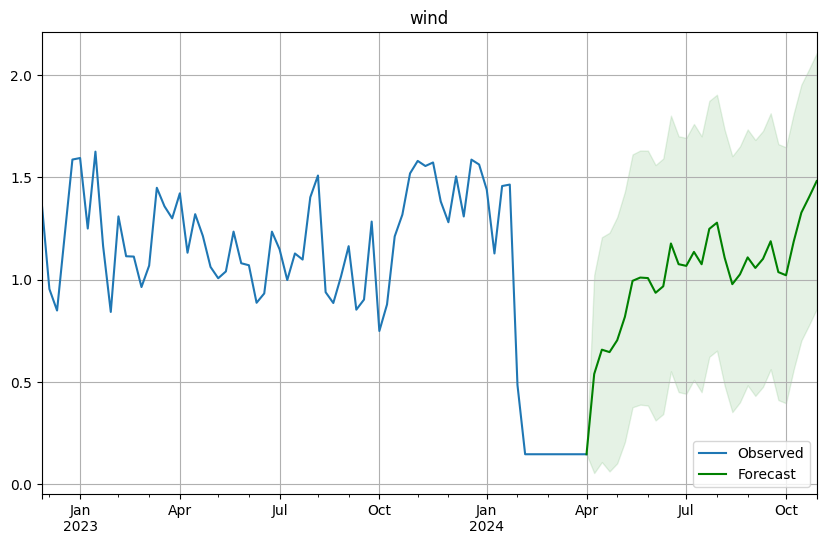
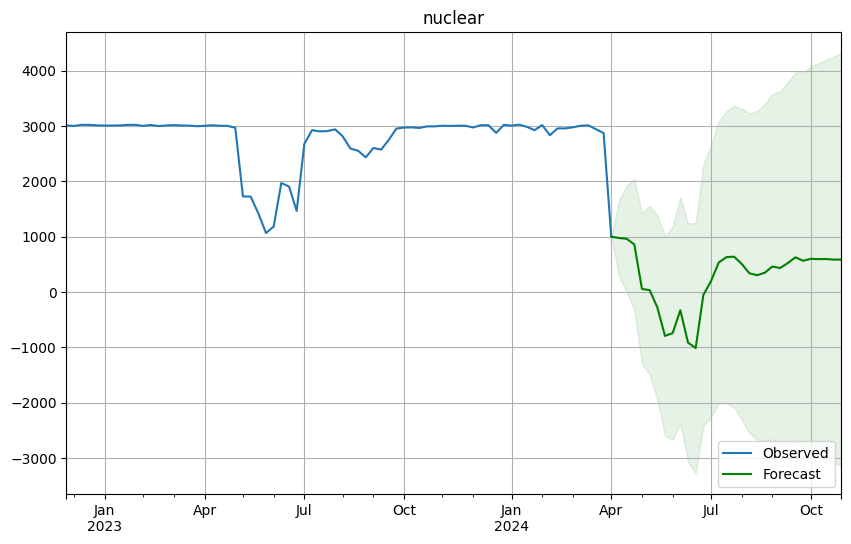

In [32]:
plot_forecast(models, energy_types, forecast_horizon)